In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## CUDA available?

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Downloading MNIST dataset

In [5]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True) # we take only 64 images at a time because of the amount of ROM available. Typically we take a power of 2.
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

## The Neural Network

In [6]:
# Define the neural network with variable layers, neurons, and dropout
class FlexibleNetwork(nn.Module):
    def __init__(self, layer_sizes, dropout_rate=0.5):
        super(FlexibleNetwork, self).__init__()
        self.layers = nn.ModuleList()
        
        # Create the layers based on the provided layer sizes
        input_size = 28 * 28  # Assuming input is a flattened 28x28 image
        for output_size in layer_sizes:
            self.layers.append(nn.Linear(input_size, output_size))
            input_size = output_size
        self.output_layer = nn.Linear(input_size, 10)  # Output layer for 10 classes
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        for layer in self.layers:
            x = self.relu(layer(x))
            x = self.dropout(x)  # Apply dropout after each hidden layer
        x = self.output_layer(x)
        return x

## Training Function

In [7]:
def train_model(label='Training', layer_sizes=None, dropout_rate=0.5, optimizer_type='Adam', reg_type='None', reg_lambda=0.0, momentum=None, n_epochs=5):
    model = FlexibleNetwork(layer_sizes, dropout_rate=dropout_rate)
    criterion = nn.CrossEntropyLoss()

    # Add optimizer if specified
    if optimizer_type == 'SGD':
        if momentum is not None and momentum > 0:
            optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=momentum)
        else:
            optimizer = optim.SGD(model.parameters(), lr=0.01)  # SGD without momentum
    elif optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.01)
    else:
        optimizer = None

    train_losses = []
    test_losses = []

    print(f"\nExperiment: {label}")
    # Training loop
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader: # loop over each batch
            if optimizer is not None:
                optimizer.zero_grad() # zero the parameter gradients
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Apply regularization if specified
            if reg_type == 'L1':
                l1_norm = sum(param.abs().sum() for param in model.parameters()) # L1 norm of all parameters
                loss += reg_lambda * l1_norm # add L1 regularization to loss
            elif reg_type == 'L2':
                l2_norm = sum(param.pow(2).sum() for param in model.parameters()) # L2 norm of all parameters
                loss += reg_lambda * l2_norm # add L2 regularization to loss

            loss.backward() # Compute gradients
            if optimizer is not None:
                optimizer.step() # update weights
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Evaluation on test set
        model.eval() # switch to evaluation mode
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad(): # disable gradient calculation for efficiency
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                
                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_loss = test_loss / len(test_loader)
        test_losses.append(test_loss)
        accuracy = 100 * correct / total

        # Print statistics
        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {epoch_loss:.4f} | Test Loss: {test_loss:.4f} | Accuracy: {accuracy:.2f}%")
    
    return train_losses, test_losses

## Default config

In [8]:
# Define the default configuration
default_config = {
    "layer_sizes": [128, 64],
    "dropout_rate": 0.0,
    "optimizer_type": "Adam",
    "reg_type": "None",
    "reg_lambda": 0.001,
    "momentum": None,
    "n_epochs": 5,
    "label": "Default Experiment"
}

## Result handler

In [9]:
def result_handler(experiment_configs):
    results = {}
    for config in experiment_configs:
        label = config["label"]
        train_losses, test_losses = train_model(
            label=label,
            layer_sizes=config["layer_sizes"],
            dropout_rate=config["dropout_rate"],
            optimizer_type=config["optimizer_type"],
            reg_type=config["reg_type"],
            reg_lambda=config["reg_lambda"],
            momentum=config["momentum"],
            n_epochs=config["n_epochs"]
        )
        results[label] = {"train_losses": train_losses, "test_losses": test_losses}
    return results

## Plot handler

In [10]:
def plot_handler(results, experiment_configs):
    num_experiments = len(experiment_configs)
    fig, axs = plt.subplots(1, num_experiments, figsize=(5 * num_experiments, 5), sharey=True)
    epochs = range(1, default_config["n_epochs"] + 1)
    for i, (label, data) in enumerate(results.items()):
        axs[i].plot(epochs, data["train_losses"], marker='o', label="Train Loss")
        axs[i].plot(epochs, data["test_losses"], marker='o', linestyle='--', label="Test Loss")
        axs[i].set_title(label)
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel('Loss')
        axs[i].legend()
    plt.tight_layout()
    plt.show()

## 1. Regularization


Experiment: Default


Epoch 1/5 | Train Loss: 0.2475 | Test Loss: 0.1391 | Accuracy: 95.81%
Epoch 2/5 | Train Loss: 0.1455 | Test Loss: 0.1553 | Accuracy: 95.80%
Epoch 3/5 | Train Loss: 0.1217 | Test Loss: 0.1615 | Accuracy: 96.13%
Epoch 4/5 | Train Loss: 0.1102 | Test Loss: 0.1479 | Accuracy: 96.34%
Epoch 5/5 | Train Loss: 0.0991 | Test Loss: 0.1301 | Accuracy: 96.88%

Experiment: L1(0.003)
Epoch 1/5 | Train Loss: 1.6329 | Test Loss: 0.6079 | Accuracy: 81.51%
Epoch 2/5 | Train Loss: 1.3888 | Test Loss: 0.5521 | Accuracy: 83.20%
Epoch 3/5 | Train Loss: 1.3575 | Test Loss: 0.5486 | Accuracy: 84.16%
Epoch 4/5 | Train Loss: 1.3391 | Test Loss: 0.6101 | Accuracy: 80.73%
Epoch 5/5 | Train Loss: 1.3359 | Test Loss: 0.5553 | Accuracy: 83.14%

Experiment: L1(0.002)
Epoch 1/5 | Train Loss: 1.3545 | Test Loss: 0.3564 | Accuracy: 89.55%
Epoch 2/5 | Train Loss: 1.1211 | Test Loss: 0.4131 | Accuracy: 87.67%
Epoch 3/5 | Train Loss: 1.0813 | Test Loss: 0.4484 | Accuracy: 86.32%
Epoch 4/5 | Train Loss: 1.0618 | Test Loss: 

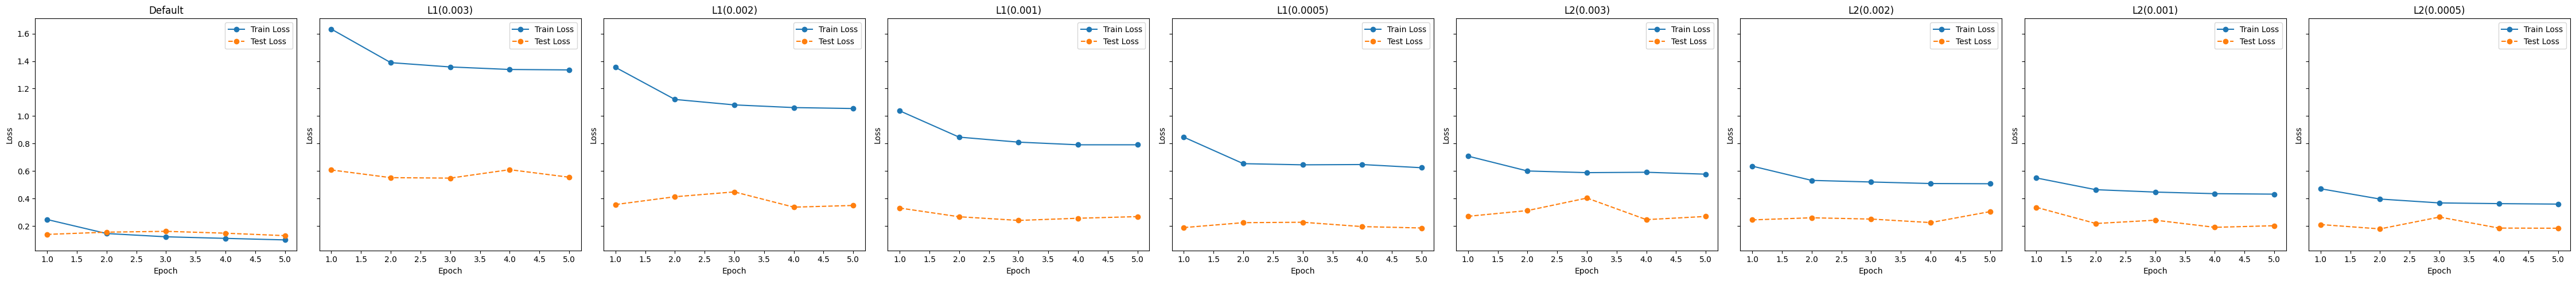

In [11]:
reg_configs = [
    {**default_config, "label": "Default"},
    {**default_config, "reg_type": "L1", "reg_lambda": 0.003, "label": "L1(0.003)"},
    {**default_config, "reg_type": "L1", "reg_lambda": 0.002, "label": "L1(0.002)"},
    {**default_config, "reg_type": "L1", "reg_lambda": 0.001, "label": "L1(0.001)"},
    {**default_config, "reg_type": "L1", "reg_lambda": 0.0005, "label": "L1(0.0005)"},
    {**default_config, "reg_type": "L2", "reg_lambda": 0.003, "label": "L2(0.003)"},
    {**default_config, "reg_type": "L2", "reg_lambda": 0.002, "label": "L2(0.002)"},
    {**default_config, "reg_type": "L2", "reg_lambda": 0.001, "label": "L2(0.001)"},
    {**default_config, "reg_type": "L2", "reg_lambda": 0.0005, "label": "L2(0.0005)"},
]
reg_results = result_handler(reg_configs)
plot_handler(reg_results, reg_configs)

## 2. Dropout


Experiment: Drop(0.2)
Epoch 1/5 | Train Loss: 0.3393 | Test Loss: 0.1709 | Accuracy: 94.81%
Epoch 2/5 | Train Loss: 0.2479 | Test Loss: 0.1634 | Accuracy: 95.31%
Epoch 3/5 | Train Loss: 0.2313 | Test Loss: 0.1567 | Accuracy: 95.91%
Epoch 4/5 | Train Loss: 0.2196 | Test Loss: 0.1543 | Accuracy: 95.83%
Epoch 5/5 | Train Loss: 0.2094 | Test Loss: 0.1776 | Accuracy: 95.50%

Experiment: Drop(0.4)
Epoch 1/5 | Train Loss: 0.5027 | Test Loss: 0.2027 | Accuracy: 93.94%
Epoch 2/5 | Train Loss: 0.3807 | Test Loss: 0.2009 | Accuracy: 94.36%
Epoch 3/5 | Train Loss: 0.3555 | Test Loss: 0.1755 | Accuracy: 95.21%
Epoch 4/5 | Train Loss: 0.3475 | Test Loss: 0.1808 | Accuracy: 95.32%
Epoch 5/5 | Train Loss: 0.3353 | Test Loss: 0.1869 | Accuracy: 95.02%

Experiment: Drop(0.6)
Epoch 1/5 | Train Loss: 0.5089 | Test Loss: 0.2111 | Accuracy: 94.00%
Epoch 2/5 | Train Loss: 0.3920 | Test Loss: 0.2003 | Accuracy: 94.61%
Epoch 3/5 | Train Loss: 0.3649 | Test Loss: 0.1797 | Accuracy: 94.99%
Epoch 4/5 | Train Los

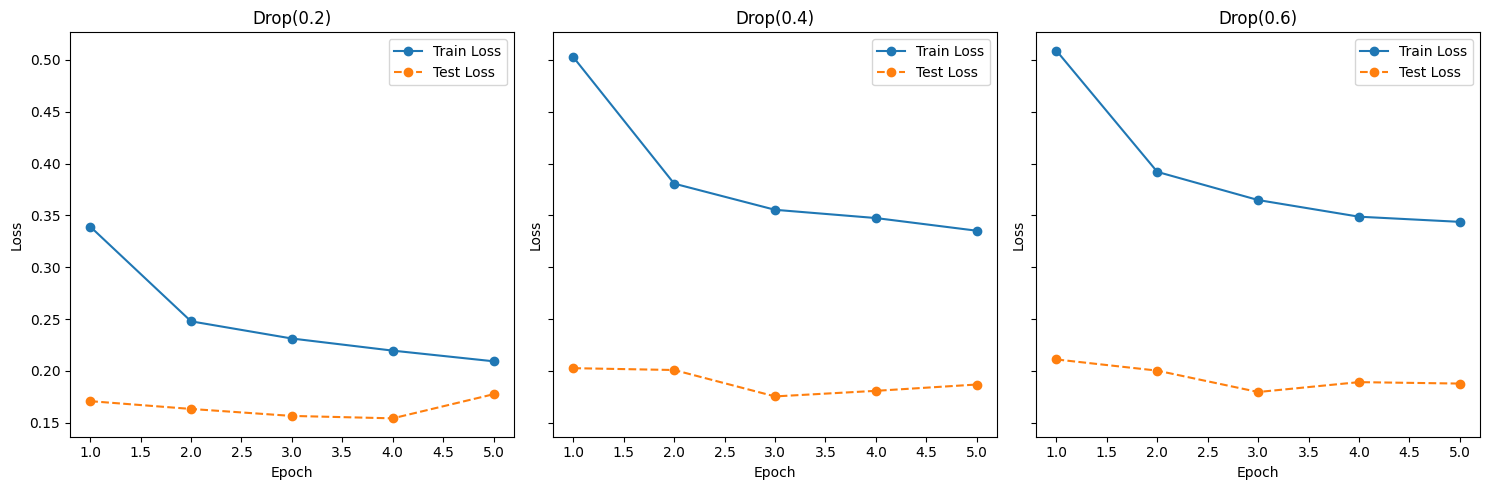

In [12]:
drop_configs = [
    {**default_config, "dropout_rate": 0.2, "label": "Drop(0.2)"},
    {**default_config, "dropout_rate": 0.4, "label": "Drop(0.4)"},
    {**default_config, "dropout_rate": 0.4, "label": "Drop(0.6)"},
]

drop_results = result_handler(drop_configs)
plot_handler(drop_results, drop_configs)

## 3. Layers


Experiment: Small Network (64, 32)
Epoch 1/5 | Train Loss: 0.2643 | Test Loss: 0.1844 | Accuracy: 94.44%
Epoch 2/5 | Train Loss: 0.1473 | Test Loss: 0.1492 | Accuracy: 95.65%
Epoch 3/5 | Train Loss: 0.1238 | Test Loss: 0.1461 | Accuracy: 95.97%
Epoch 4/5 | Train Loss: 0.1092 | Test Loss: 0.1625 | Accuracy: 95.53%
Epoch 5/5 | Train Loss: 0.1027 | Test Loss: 0.1599 | Accuracy: 96.07%

Experiment: Medium Network (128, 64, 32)
Epoch 1/5 | Train Loss: 0.2737 | Test Loss: 0.1535 | Accuracy: 95.31%
Epoch 2/5 | Train Loss: 0.1482 | Test Loss: 0.1515 | Accuracy: 95.85%
Epoch 3/5 | Train Loss: 0.1242 | Test Loss: 0.1068 | Accuracy: 97.18%
Epoch 4/5 | Train Loss: 0.1085 | Test Loss: 0.1314 | Accuracy: 96.63%
Epoch 5/5 | Train Loss: 0.1043 | Test Loss: 0.1438 | Accuracy: 96.53%

Experiment: Large Network (256, 128, 64, 32)
Epoch 1/5 | Train Loss: 0.2950 | Test Loss: 0.2497 | Accuracy: 93.40%
Epoch 2/5 | Train Loss: 0.1686 | Test Loss: 0.1345 | Accuracy: 96.66%
Epoch 3/5 | Train Loss: 0.1349 | Tes

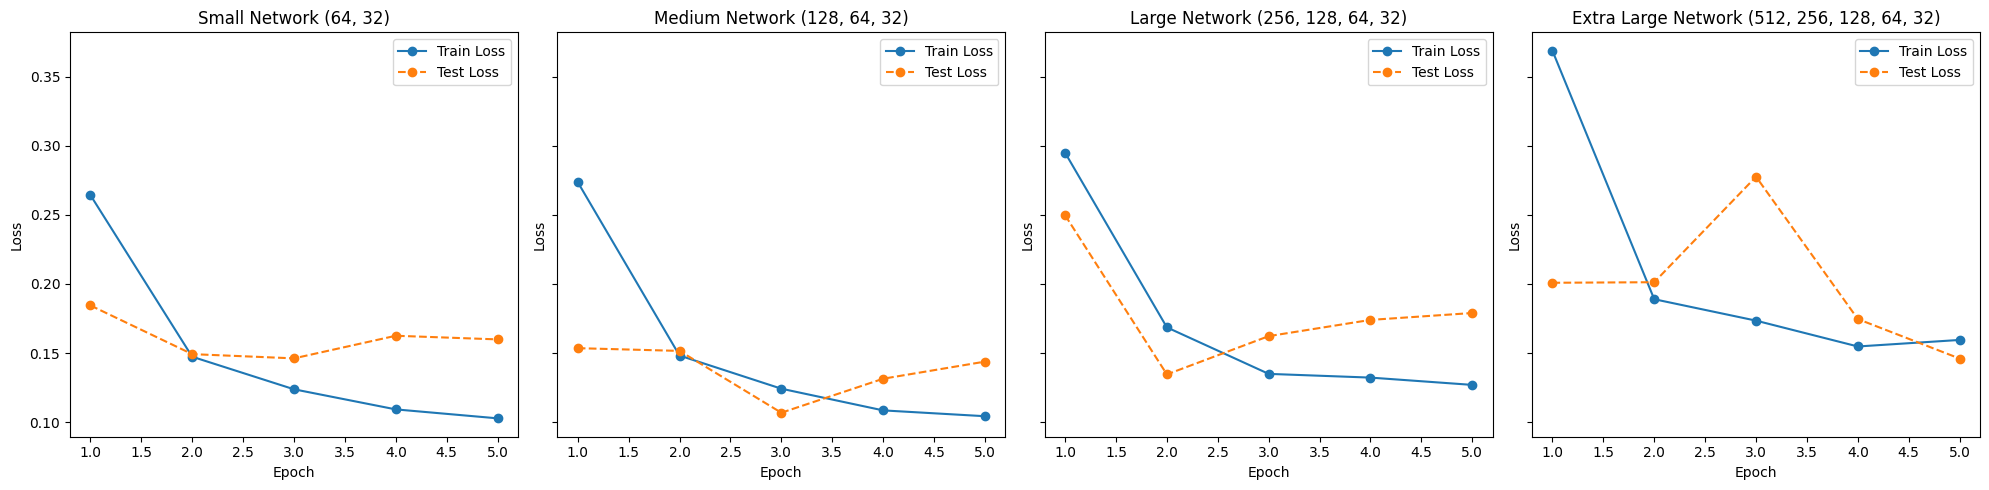

In [13]:
layer_configs = [
    {**default_config, "layer_sizes": [64, 32], "label": "Small Network (64, 32)"},
    {**default_config, "layer_sizes": [128, 64, 32], "label": "Medium Network (128, 64, 32)"},
    {**default_config, "layer_sizes": [256, 128, 64, 32], "label": "Large Network (256, 128, 64, 32)"},
    {**default_config, "layer_sizes": [512, 256, 128, 64, 32], "label": "Extra Large Network (512, 256, 128, 64, 32)"}
]

layer_results = result_handler(layer_configs)
plot_handler(layer_results, layer_configs)

## 4. Momentum


Experiment: SGD
Epoch 1/5 | Train Loss: 1.7668 | Test Loss: 0.8516 | Accuracy: 79.72%
Epoch 2/5 | Train Loss: 0.5849 | Test Loss: 0.4316 | Accuracy: 88.04%
Epoch 3/5 | Train Loss: 0.4036 | Test Loss: 0.3541 | Accuracy: 89.77%
Epoch 4/5 | Train Loss: 0.3542 | Test Loss: 0.3240 | Accuracy: 90.63%
Epoch 5/5 | Train Loss: 0.3261 | Test Loss: 0.3030 | Accuracy: 91.19%

Experiment: SGD(0.3)
Epoch 1/5 | Train Loss: 1.4118 | Test Loss: 0.5579 | Accuracy: 85.60%
Epoch 2/5 | Train Loss: 0.4472 | Test Loss: 0.3654 | Accuracy: 89.48%
Epoch 3/5 | Train Loss: 0.3522 | Test Loss: 0.3177 | Accuracy: 91.01%
Epoch 4/5 | Train Loss: 0.3153 | Test Loss: 0.2889 | Accuracy: 91.81%
Epoch 5/5 | Train Loss: 0.2895 | Test Loss: 0.2721 | Accuracy: 92.17%

Experiment: SGD(0.6)
Epoch 1/5 | Train Loss: 0.9876 | Test Loss: 0.3901 | Accuracy: 88.93%
Epoch 2/5 | Train Loss: 0.3528 | Test Loss: 0.3004 | Accuracy: 91.42%
Epoch 3/5 | Train Loss: 0.2890 | Test Loss: 0.2591 | Accuracy: 92.72%
Epoch 4/5 | Train Loss: 0.244

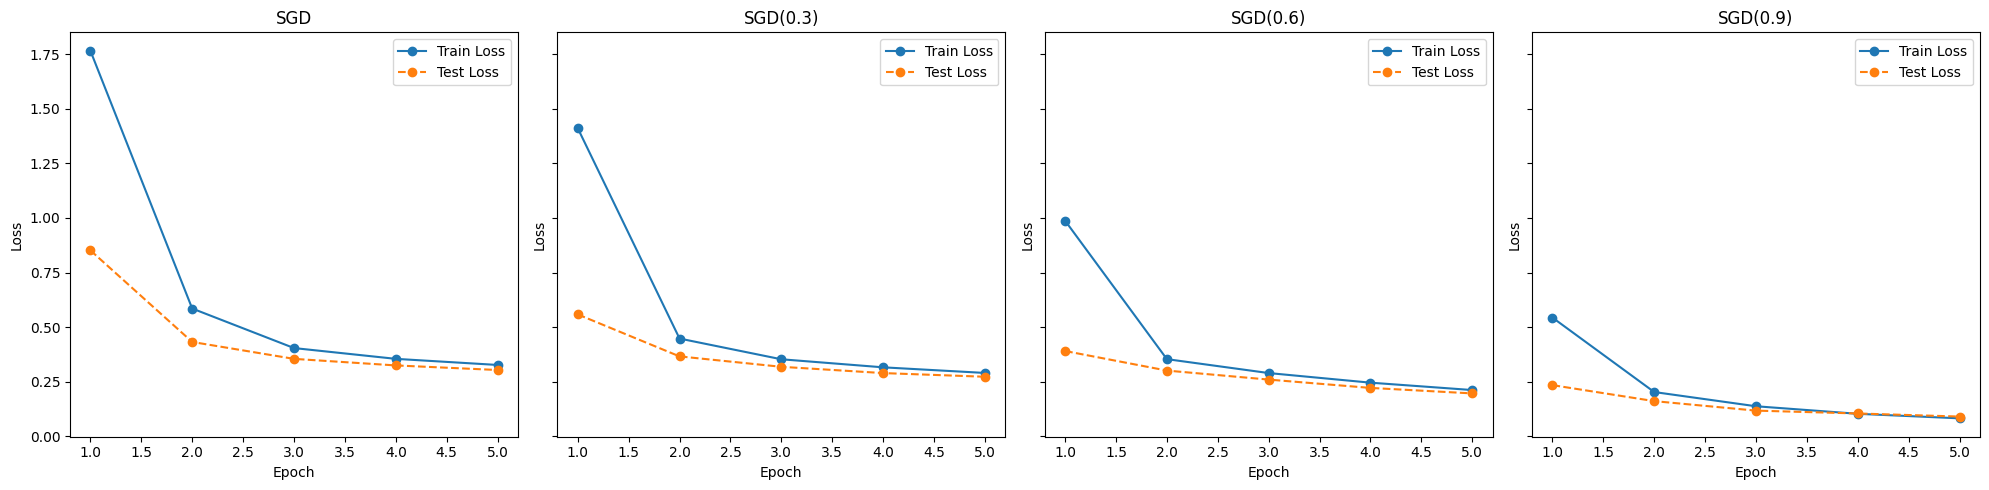

In [14]:
mom_configs = [
    {**default_config, "optimizer_type": "SGD", "label": "SGD"},
    {**default_config, "optimizer_type": "SGD", "momentum": 0.3, "label": "SGD(0.3)"},
    {**default_config, "optimizer_type": "SGD", "momentum": 0.6, "label": "SGD(0.6)"},
    {**default_config, "optimizer_type": "SGD", "momentum": 0.9, "label": "SGD(0.9)"}
]

mom_results = result_handler(mom_configs)
plot_handler(mom_results, mom_configs)